# **Spatio-temporal clustering for syndromic surveillance**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import cleaned and prepared data of consultations in RW
rw_data = pd.read_pickle("data/rw-cleaned-prepared-dynamic-data-phase1.pickle")

# Data selection
Only pick columns relevant for the spatio-temporal clustering of symptoms. Relevant columns are:
1. time = "medical_case_consultation_date"
2. space
    - hf location = "health_facility_longitude" & "health_facility_latitude"
    - location of patient's home: "BD9 - Village (Umudugudu) - 8062" (cleaned in columns: ....)
3. demographic: 
    - age = "patient_birthdate"
    - sex = "patient_gender"
    - columns with BD in the beginning
    - columns with BM in the beginning
    - diagnosis (= potential labels for clusters) = columns with DF (, CH, A) in the beginning
4. symptoms = columns with CC, PE and (S, OS, A) in the beginning

In [3]:
columns_to_keep = [
    "medical_case_id",
    "medical_case_consultation_date",
    "patient_id",
    "patient_birthdate",
    "patient_gender",
    "health_facility_id",
    "health_facility_group_id",
    "health_facility_longitude",
    "health_facility_latitude",
    "health_facility_name"
]

demographic_columns = [
    "patient_age",
    "patient_gender"
]

spatio_temporal_columns = [
    "medical_case_consultation_date",
    "health_facility_longitude",
    "health_facility_latitude",
    "health_facility_name",
]

In [4]:
# get symptom data
rw_symptoms = rw_data[[col for col in rw_data.columns if col[0:2] == "CC" or col[0:2] == "PE"]]

# select data for clustering
data = rw_data[np.concatenate((demographic_columns, rw_symptoms.columns))]

In [5]:
# print list of columns used as features for clustering
for col in data.columns:
    print(col)

patient_age
patient_gender
CC21 - General - 8341
CC10 - Skin / hair - 8346
CC22 - General Assessment - 8352
CC23 - Yellow appearing skin or eyes (jaundice) - 7351
CC30 - Malformation of birth anomaly - 7389
CC33 - Fever or convulsions or lethargy - 7391
CC17 - Gastrointestinal (diarrhea, vomiting, feeding) - 7875
CC31 - Injuries (birth and non-birth related) - 7977
CC11 - Eye - 7803
CC13 - Respiratory (Cough or difficult breathing) - 7808
CC27 - Eye complaint - 8066
CC28 - Ear or mouth complaint - 8072
CC26 - Skin - 8073
CC25 - Diarrhea, abdominal, gastro-intestinal - 8076
CC32 - Fever - 8081
CC12 - Ear/Throat/Mouth - 8342
CC18 - Accident /Muskulo-skeletal (incl. burns, wounds, poison) - 8343
CC29 - Feeding problem or weight concern - 8347
CC24 - Respiratory - 8370
CC15 - Genitourinary (UTI, STI) - 8371
CC16 - Neuro (Headache, stiff neck, neck pain) - 8372
CC37 - Follow-up visit for a previous problem - 7521
CC36 - Other - 8122
CC35 - Other - 8120
PE163 - Umbilicus draining pus - 7655


# Quality control of selected data for clustering

## Low variance

<AxesSubplot:title={'center':'Low variance columns'}>

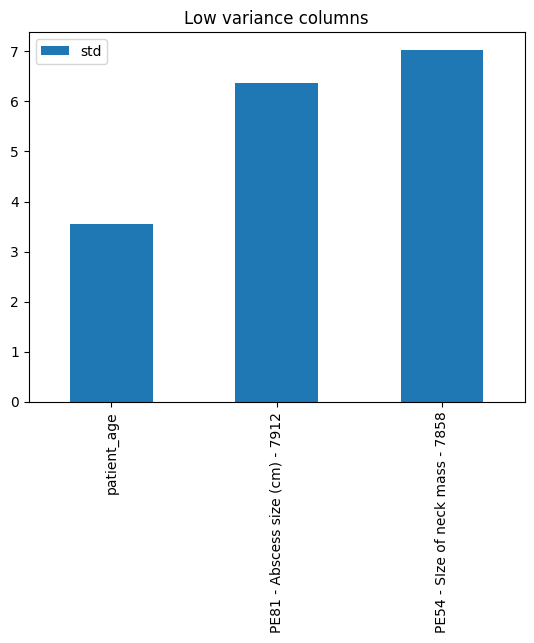

In [6]:
description_data = data.describe()
description_data 

# check for low variance columns
low_var_threshold = 10 # TODO should be different for binary columns
var_rw_data = description_data.loc[["std"]].transpose().dropna().sort_values(by=["std"])

# plot low variance columns
var_rw_data[var_rw_data["std"] <= low_var_threshold].plot(kind="bar", rot=90, title="Low variance columns")

## Missingness

group
(-0.001, 1.0]     26
(1.0, 10.0]        0
(10.0, 20.0]       0
(20.0, 30.0]       0
(30.0, 40.0]       4
(40.0, 50.0]       0
(50.0, 60.0]       1
(60.0, 70.0]       5
(70.0, 80.0]       0
(80.0, 90.0]       7
(90.0, 100.0]    133
dtype: int64


<AxesSubplot:title={'center':'Number of features per NAN amount range'}, xlabel='group'>

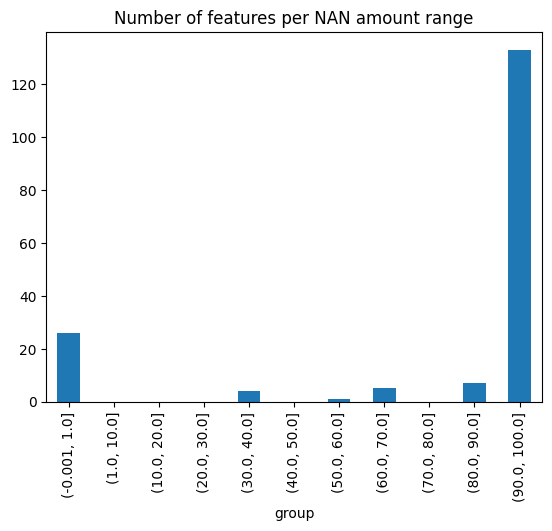

In [7]:
# number of nan per column
nnan_data = data.isnull().sum(axis = 0).to_frame(name="nnan").sort_values("nnan", ascending=False)
nnan_data["nnan_share_in_%"] = nnan_data["nnan"] / data.shape[0] * 100
nnan_data["group"] = pd.cut(nnan_data["nnan_share_in_%"], bins=[0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], right=True, include_lowest=True)
print(nnan_data.groupby("group").size())
nnan_data.groupby("group").size().plot(kind="bar", title="Number of features per NAN amount range")

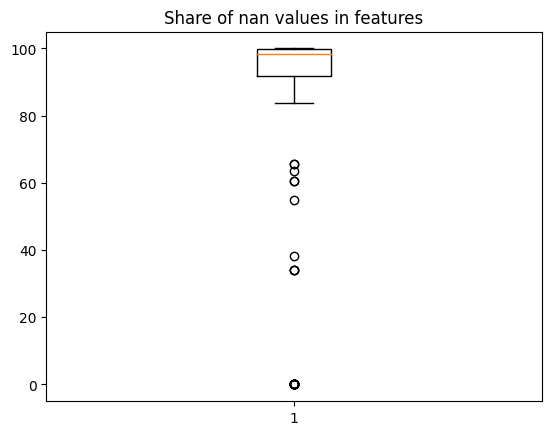

In [8]:
# boxplot of share of nan values for each feautures
plt.boxplot(nnan_data["nnan_share_in_%"])
plt.title("Share of nan values in features")
plt.show()

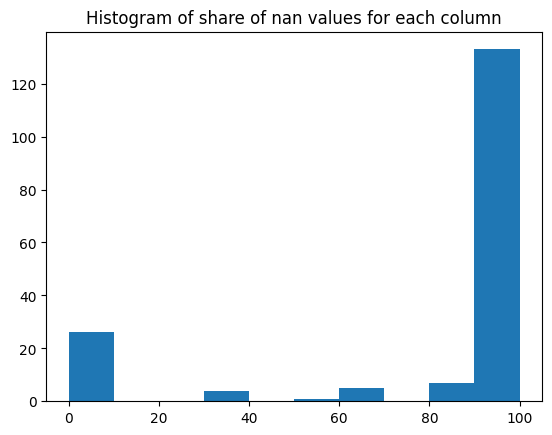

In [9]:
# distribution of share of nan values for each column
plt.hist(nnan_data["nnan_share_in_%"])
plt.title("Histogram of share of nan values for each column")
plt.show()

In [10]:
# columns with no nan
print(nnan_data[nnan_data["nnan"] == 0].size/nnan_data.size*100, "%", "of columns contain no NaN values!")
nnan_data[nnan_data["nnan"] == 0].index

14.204545454545455 % of columns contain no NaN values!


Index(['CC22 - General Assessment - 8352',
       'CC23 - Yellow appearing skin or eyes (jaundice) - 7351',
       'CC30 - Malformation of birth anomaly - 7389',
       'CC33 - Fever or convulsions or lethargy - 7391',
       'CC28 - Ear or mouth complaint - 8072', 'CC21 - General - 8341',
       'CC10 - Skin / hair - 8346',
       'CC17 - Gastrointestinal (diarrhea, vomiting, feeding) - 7875',
       'CC31 - Injuries (birth and non-birth related) - 7977',
       'CC11 - Eye - 7803',
       'CC13 - Respiratory (Cough or difficult breathing) - 7808',
       'CC27 - Eye complaint - 8066', 'CC36 - Other - 8122',
       'CC26 - Skin - 8073',
       'CC25 - Diarrhea, abdominal, gastro-intestinal - 8076',
       'CC32 - Fever - 8081', 'CC12 - Ear/Throat/Mouth - 8342',
       'CC18 - Accident /Muskulo-skeletal (incl. burns, wounds, poison) - 8343',
       'CC29 - Feeding problem or weight concern - 8347',
       'CC24 - Respiratory - 8370', 'CC15 - Genitourinary (UTI, STI) - 8371',
       'CC

17.045454545454543 % of columns contain less or equal than 40 % of NaN values!


<AxesSubplot:title={'center':'Columns with less or equal than 40% of NaN values'}>

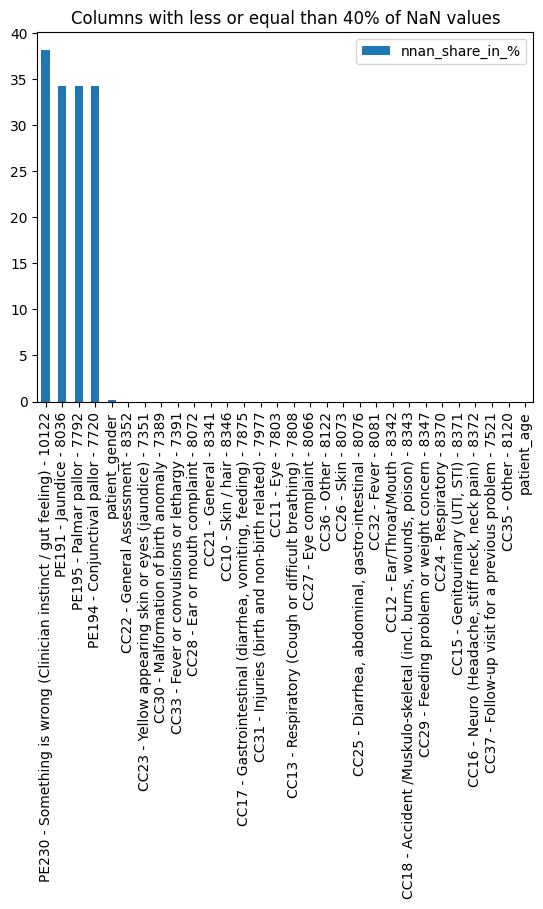

In [11]:
# plot columns with too many NaN values
nnan_threshold = 40 # in %
print(nnan_data[nnan_data["nnan_share_in_%"] <= nnan_threshold].shape[0] / nnan_data.shape[0] * 100, "%", "of columns contain less or equal than", nnan_threshold,"%", "of NaN values!")
nnan_data[nnan_data["nnan_share_in_%"]  <= nnan_threshold].plot(kind="bar", y="nnan_share_in_%", rot=90, title=f"Columns with less or equal than {nnan_threshold}% of NaN values")

# Data Cleaning

In [12]:
# convert "patient_gender" column into numeric binary column
data["patient_gender"] = [1 if gender == "female" else 0 for gender in data["patient_gender"]]

C:\Users\sidla\AppData\Local\Temp\ipykernel_16796\2608160854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["patient_gender"] = [1 if gender == "female" else 0 for gender in data["patient_gender"]]


In [13]:
# convert "yes"/"no" columns and "Absent"/"Present" columns  to binary columns
data = data.apply(lambda x : x.replace({"Yes": 1, "No": 0, "Absent": 0, "Present": 1}), axis=1)

In [14]:
data["PE230 - Something is wrong (Clinician instinct / gut feeling) - 10122"].unique()

array([ 0., nan,  1.])

In [15]:
data["PE193 - Bite wound - 8395"].unique()

array([nan,  0.,  1.])

In [16]:
# drop columns with too many NaN values based on nnan_threshold and store them as features
features = data[nnan_data[nnan_data["nnan_share_in_%"]  <= nnan_threshold].index]

# print list of columns dropped because of this cleaning step
print("columns used as features:", features.columns)

columns used as features: Index(['PE230 - Something is wrong (Clinician instinct / gut feeling) - 10122',
       'PE191 - Jaundice - 8036', 'PE195 - Palmar pallor - 7792',
       'PE194 - Conjunctival pallor - 7720', 'patient_gender',
       'CC22 - General Assessment - 8352',
       'CC23 - Yellow appearing skin or eyes (jaundice) - 7351',
       'CC30 - Malformation of birth anomaly - 7389',
       'CC33 - Fever or convulsions or lethargy - 7391',
       'CC28 - Ear or mouth complaint - 8072', 'CC21 - General - 8341',
       'CC10 - Skin / hair - 8346',
       'CC17 - Gastrointestinal (diarrhea, vomiting, feeding) - 7875',
       'CC31 - Injuries (birth and non-birth related) - 7977',
       'CC11 - Eye - 7803',
       'CC13 - Respiratory (Cough or difficult breathing) - 7808',
       'CC27 - Eye complaint - 8066', 'CC36 - Other - 8122',
       'CC26 - Skin - 8073',
       'CC25 - Diarrhea, abdominal, gastro-intestinal - 8076',
       'CC32 - Fever - 8081', 'CC12 - Ear/Throat/Mouth -

# Clustering
In the following the previously selected and cleaned features are clustered. Since the underlying data comes from CDSS, a lot of NAN values are systematically present. To address this, there will be diverse clustering runs:
1. clustering of raw features with NAN values
2. K-Means clustering of the features containing no NAN values
3. K-Means clustering of all features with imputed values (mean for continues features and median for categorical features)
4. K-Means clustering of all features with imputed values and additional binary feature to track the imputed values for each feature

Please note, that K-Means is chosen for clustering whenever applicable due to experience from previous work on clustering CDSS data at IGH. 
    

cluster three datasets different regarding how missingness is addressed
        1. symptom and demographic data with NAN values --> use kmeans variation that handles NAN (kmeans++ or fuzzy clustering or GMM)
        2. impute NAN as if missingness is at random: use mean for continues and median for binary
        3. impute NAN as above. however, we also always add a binary column keeping track if value of respective feature is imputed or not --> analyse if imputation is picked up by clusters

In [17]:
!pip install yellowbrick

You should consider upgrading via the 'C:\Users\sidla\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [18]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

## Clustering of raw features (with NAN values)

In [50]:
pip install scikit-learn-extra

  Using cached scikit-learn-extra-0.2.0.tar.gz (813 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build scikit-learn-extra
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for scikit-learn-extra (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [49 lines of output]
      C:\Users\sidla\AppData\Local\Temp\pip-build-env-6wqftbpc\overlay\Lib\site-packages\setuptools\dist.py:788: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
        warnings.warn(
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-310
      creating build\lib.win-amd64-cpython-310\benchmarks
      copying benchmarks\bench_rbfsampler_fastfood.py -> build\lib.win-amd64-cpython-310\benchmarks
      copying benchmarks\__init__.py -> build\lib.win-amd64-cpython-310\benchmarks
      creating build\lib.win-amd64-cpython-310\sklearn_extra
      copying sklearn_extra\_version.py -> build\lib.win-amd64-cpython-310\sklearn_extra
      copy

In [51]:
from sklearn_extra.cluster import KMedoids

# Finding the optimal number of clusters using the Elbow method with yellowbrick
model = KMedoids(n_init =10)
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(features)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

ModuleNotFoundError: No module named 'sklearn_extra'

In [ ]:
# Performing clustering with the optimal number of clusters
kmoids = KMedoids(n_clusters=n_clusters, n_init=10, random_state=0).fit(features)

# Adding the column 'cluster' to the dataframe
features_raw = features.copy()
features_raw["cluster"] = kmoids.labels_

In [52]:
!pip install kmodes

In [ ]:
if False:
    # Initialize the KModes algorithm with 3 clusters and let it automatically detect categorical features
    kmodes = KModes(n_clusters=3)
    clusters = kmodes.fit_predict(features, categorical=None, missing='value')

    # Get the cluster centroids and the column indices of the categorical features
    centroids = kmodes.cluster_centroids_
    cat_cols = np.unique(np.where(np.isnan(centroids))[1])

In [55]:
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes

# Compute the  within-cluster sum of squaresWCSS for different numbers of clusters
# TODO filter for "nan" in the doc https://kprototypes.readthedocs.io/_/downloads/en/latest/pdf/
wcss = []
for i in range(1, 11):
    kproto = KPrototypes(n_clusters=i) #, categorical=cat_cols
    kproto.fit(features, missing='value')
    wcss.append(kproto.cost_)

# Plot the WCSS results
plt.plot(range(1, 11), wcss)
plt.title("Elbow Method)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

TypeError: KPrototypes.fit() got an unexpected keyword argument 'missing'

## K-Means clustering of the features containing no NAN values

In [20]:
# Retrieve all features with no nan value
features_no_nan = features.dropna(axis=1)
print("Dropping columns with NAN, leads to", features.shape[1]-features_no_nan.shape[1],"less columns.")
print(features_no_nan.shape[1], "columns are used for clustering, which are:")
for col in features_no_nan.columns:
    print(col)

Dropping columns with NAN, leads to 4 less columns.
26 columns are used for clustering, which are:
patient_gender
CC22 - General Assessment - 8352
CC23 - Yellow appearing skin or eyes (jaundice) - 7351
CC30 - Malformation of birth anomaly - 7389
CC33 - Fever or convulsions or lethargy - 7391
CC28 - Ear or mouth complaint - 8072
CC21 - General - 8341
CC10 - Skin / hair - 8346
CC17 - Gastrointestinal (diarrhea, vomiting, feeding) - 7875
CC31 - Injuries (birth and non-birth related) - 7977
CC11 - Eye - 7803
CC13 - Respiratory (Cough or difficult breathing) - 7808
CC27 - Eye complaint - 8066
CC36 - Other - 8122
CC26 - Skin - 8073
CC25 - Diarrhea, abdominal, gastro-intestinal - 8076
CC32 - Fever - 8081
CC12 - Ear/Throat/Mouth - 8342
CC18 - Accident /Muskulo-skeletal (incl. burns, wounds, poison) - 8343
CC29 - Feeding problem or weight concern - 8347
CC24 - Respiratory - 8370
CC15 - Genitourinary (UTI, STI) - 8371
CC16 - Neuro (Headache, stiff neck, neck pain) - 8372
CC37 - Follow-up visit f

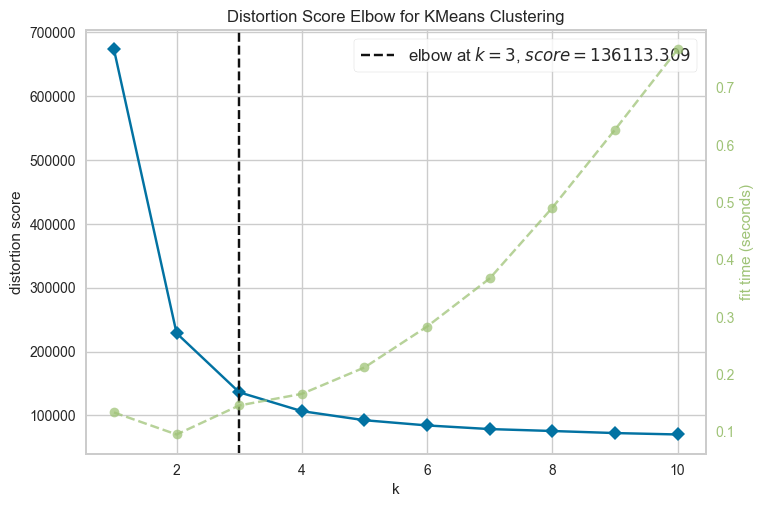

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
# Finding the optimal number of clusters using the Elbow method with yellowbrick
model = KMeans(n_init =10)
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(features_no_nan)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

In [22]:
# Performing clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(features_no_nan)

# Adding the column 'cluster' to the dataframe
features_no_nan["cluster"] = kmeans.labels_

C:\Users\sidla\AppData\Local\Temp\ipykernel_16796\3283319560.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_no_nan["cluster"] = kmeans.labels_


<AxesSubplot:title={'center':'Number of consultations per cluster'}, xlabel='cluster'>

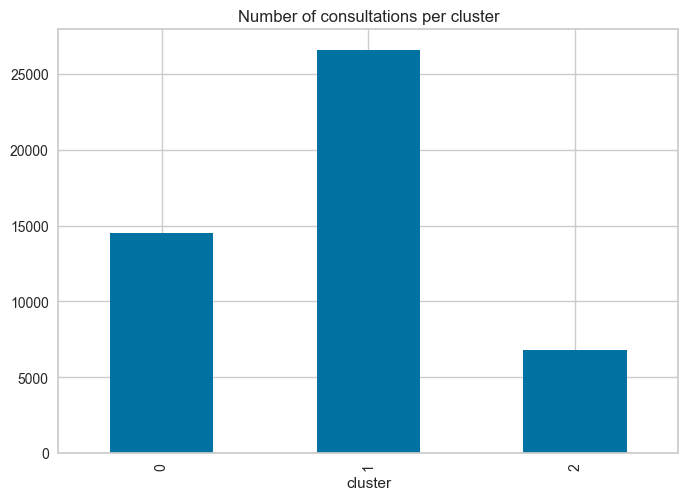

In [23]:
features_no_nan.groupby("cluster").size().plot(kind="bar", title="Number of consultations per cluster")

## K-Means with imputed features

In [24]:
imputed_features = features.copy()

In [25]:
# impute binary columns with median
for binary_col in imputed_features.nunique(dropna=True).loc[lambda x : x <= 2].index:
    imputed_features[binary_col].fillna(imputed_features[binary_col].median(), inplace=True)

In [26]:
# impute continues variables with mean
# NOTE we assume all remaining columns are not binary and thus continues
for nan_col in imputed_features.isna().sum().loc[lambda x : x != 0].index:
    imputed_features[nan_col].fillna(imputed_features[nan_col].mean(), inplace=True)

In [27]:
print("Before imputation:", features.isna().sum().sum(), "NAN values in", features.isna().sum().loc[features.isna().sum()>0].shape[0],"columns")
print("After imputation:", imputed_features.isna().sum().sum(), "NAN values in", imputed_features.isna().sum().loc[imputed_features.isna().sum()>0].shape[0],"columns")

Before imputation: 67386 NAN values in 4 columns
After imputation: 0 NAN values in 0 columns


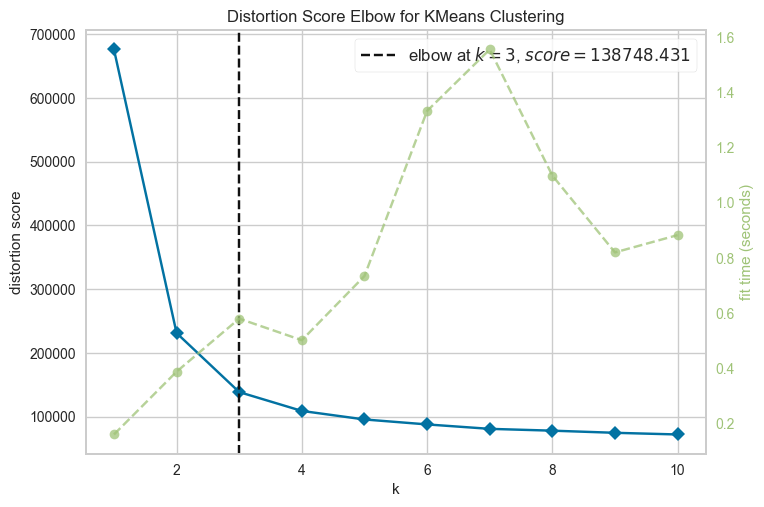

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
# Finding the optimal number of clusters using the Elbow method with yellowbrick
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(imputed_features)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

In [29]:
# Performing clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(imputed_features)

# Adding the column 'cluster' to the dataframe
imputed_features["cluster"] = kmeans.labels_

<AxesSubplot:title={'center':'Number of consultations per cluster'}, xlabel='cluster'>

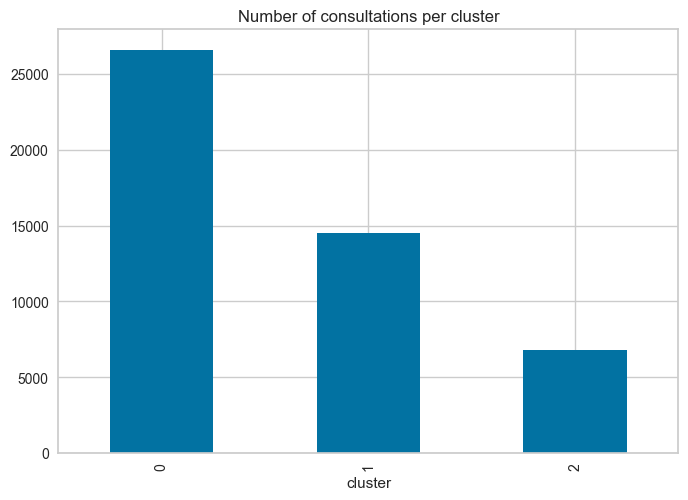

In [30]:
imputed_features.groupby("cluster").size().plot(kind="bar", title="Number of consultations per cluster")

## K-Means clustering with imputed features and feature augmentation

In [31]:
augmented_imputed_features = features.copy()

In [32]:
# impute binary columns with median
for binary_col in augmented_imputed_features.nunique(dropna=True).loc[lambda x : x <= 2].index:
    if augmented_imputed_features[binary_col].isna().sum() == 0:
        continue
    augmented_imputed_features["imputed_"+binary_col] = np.multiply(augmented_imputed_features[binary_col].isna(), 1)
    augmented_imputed_features[binary_col].fillna(augmented_imputed_features[binary_col].median(), inplace=True)


In [33]:
# impute continues variables with mean
# NOTE we assume all remaining columns are not binary and thus continues
for nan_col in augmented_imputed_features.isna().sum().loc[lambda x : x != 0].index:
    augmented_imputed_features["imputed_"+nan_col] = np.multiply(augmented_imputed_features[nan_col].isna(), 1)
    augmented_imputed_features[nan_col].fillna(augmented_imputed_features[nan_col].mean(), inplace=True)

In [34]:
print("Before imputation:", features.isna().sum().sum(), "NAN values in", features.isna().sum().loc[features.isna().sum()>0].shape[0],"columns")
print("After imputation:", augmented_imputed_features.isna().sum().sum(), "NAN values in", augmented_imputed_features.isna().sum().loc[augmented_imputed_features.isna().sum()>0].shape[0],"columns")

Before imputation: 67386 NAN values in 4 columns
After imputation: 0 NAN values in 0 columns


In [35]:
augmented_imputed_features.columns

Index(['PE230 - Something is wrong (Clinician instinct / gut feeling) - 10122',
       'PE191 - Jaundice - 8036', 'PE195 - Palmar pallor - 7792',
       'PE194 - Conjunctival pallor - 7720', 'patient_gender',
       'CC22 - General Assessment - 8352',
       'CC23 - Yellow appearing skin or eyes (jaundice) - 7351',
       'CC30 - Malformation of birth anomaly - 7389',
       'CC33 - Fever or convulsions or lethargy - 7391',
       'CC28 - Ear or mouth complaint - 8072', 'CC21 - General - 8341',
       'CC10 - Skin / hair - 8346',
       'CC17 - Gastrointestinal (diarrhea, vomiting, feeding) - 7875',
       'CC31 - Injuries (birth and non-birth related) - 7977',
       'CC11 - Eye - 7803',
       'CC13 - Respiratory (Cough or difficult breathing) - 7808',
       'CC27 - Eye complaint - 8066', 'CC36 - Other - 8122',
       'CC26 - Skin - 8073',
       'CC25 - Diarrhea, abdominal, gastro-intestinal - 8076',
       'CC32 - Fever - 8081', 'CC12 - Ear/Throat/Mouth - 8342',
       'CC18 - Acc

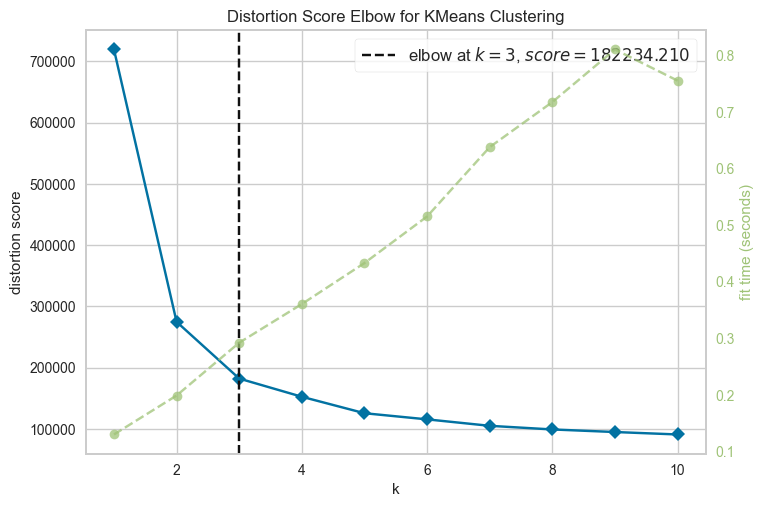

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
# Finding the optimal number of clusters using the Elbow method with yellowbrick
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(augmented_imputed_features)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

In [37]:
# Performing clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(augmented_imputed_features)

# Adding the column 'cluster' to the dataframe
augmented_imputed_features["cluster"] = kmeans.labels_

<AxesSubplot:title={'center':'Number of consultations per cluster'}, xlabel='cluster'>

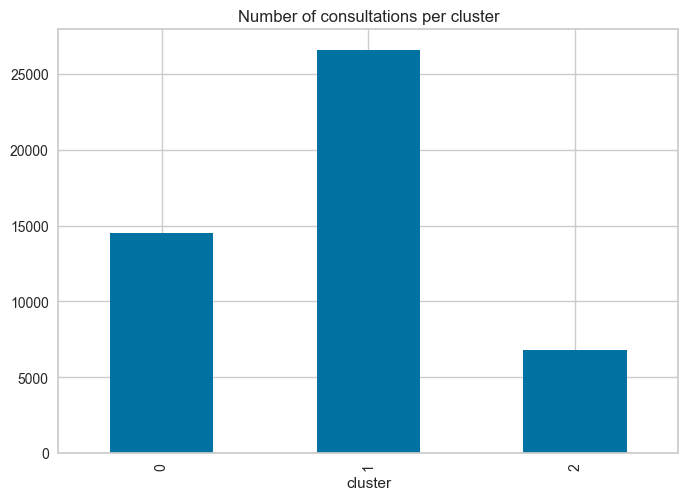

In [38]:
augmented_imputed_features.groupby("cluster").size().plot(kind="bar", title="Number of consultations per cluster")

# Spatio-temporal analysis of clusters
- spatial dimension = patient's origin (or hf location)
- temporal dimension = consultation date

Reveal:
1. number of consultations in clusters over time and space
2. demographic (age and gender) in cluster over time and space
3. symptom composition in clusters over time and space
4. diagnosis composition in clusters over time and space (Did clustering lead to  or end of the branches of the underlying decision tree of CDSS?)

In [39]:
# TODO engineer final data set with columns 
# key: consultation_date, village_name, village_long, village_lat, 
# number_consultations, age_avg, female_percentage, 
# number of 1 in symptom columns
# number of 1 in diagnosis columns